In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import logging
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import sep
import pandas as pd
import os
from astropy.table import Table, vstack

In [ ]:
from maddeb.utils import listdir_fullpath, get_data_dir_path

In [ ]:
logging.basicConfig(format="%(message)s", level=logging.INFO)
LOG = logging.getLogger(__name__)

## load the saved results

In [ ]:
density_level = "high"

In [ ]:
data_path = "/sps/lsst/users/bbiswas/MADNESS_results/" + density_level + "_density"
run_name = "kl01" # 12 to 20 galaxies
result_dir_path = os.path.join(data_path, run_name)

In [ ]:
madness_results=[]
scarlet_results=[]
actual_photometry = []
blended_photometry = []

for file_num in range(300):

    madness_results.append(pd.read_pickle(os.path.join(result_dir_path, "madness_results", str(file_num) + ".pkl")))
    scarlet_results.append(pd.read_pickle(os.path.join(data_path, "scarlet_results", str(file_num) + ".pkl")))

    actual_photometry.append(pd.read_pickle(os.path.join(data_path, "actual_photometry", str(file_num) + ".pkl")))
    blended_photometry.append(pd.read_pickle(os.path.join(data_path, "blended_photometry",  str(file_num) + ".pkl")))

madness_results = pd.concat(madness_results)
scarlet_results = pd.concat(scarlet_results)

actual_photometry = pd.concat(actual_photometry)
blended_photometry = pd.concat(blended_photometry)

In [ ]:
mask=madness_results["r_contamination"].values<5
madness_results=madness_results[mask]
scarlet_results=scarlet_results[mask]
actual_photometry=actual_photometry[mask]
blended_photometry=blended_photometry[mask]

In [ ]:
import maddeb.boxplot
import matplotlib as mpl

# Perpare data for plots

In [ ]:
import astropy.units as u
import galcheat

In [ ]:
madness_results.columns

Index(['u_covariance', 'u_actual_flux', 'u_predicted_flux', 'u_blendedness',
       'g_covariance', 'g_actual_flux', 'g_predicted_flux', 'g_blendedness',
       'r_covariance', 'r_actual_flux', 'r_predicted_flux', 'r_blendedness',
       'i_covariance', 'i_actual_flux', 'i_predicted_flux', 'i_blendedness',
       'z_covariance', 'z_actual_flux', 'z_predicted_flux', 'z_blendedness',
       'y_covariance', 'y_actual_flux', 'y_predicted_flux', 'y_blendedness',
       'galaxy_num', 'size', 'field_num', 'file_num', 'r_band_snr', 'ref_mag',
       'u_phot_flux', 'u_phot_fluxerrs', 'u_phot_flags', 'g_phot_flux',
       'g_phot_fluxerrs', 'g_phot_flags', 'r_phot_flux', 'r_phot_fluxerrs',
       'r_phot_flags', 'i_phot_flux', 'i_phot_fluxerrs', 'i_phot_flags',
       'z_phot_flux', 'z_phot_fluxerrs', 'z_phot_flags', 'y_phot_flux',
       'y_phot_fluxerrs', 'y_phot_flags', 'r_contamination', 'u_ab', 'g_ab',
       'r_ab', 'i_ab', 'z_ab', 'y_ab'],
      dtype='object')

In [ ]:
survey = galcheat.helpers.get_survey("LSST")

for band in ["u", "g", "r", "i", "y", "z"]:

    exp_time = survey.get_filter(band).full_exposure_time

    actual_phot_mag = actual_photometry[f"{band}_phot_flux"].values
    z_point = survey.get_filter(band).zeropoint
    
    actual_photometry[f"{band}_phot_mag"] = ((actual_phot_mag * u.electron / exp_time).to(u.mag(u.electron / u.s)) 
     + z_point).value
    
    madness_phot_mag = madness_results[f"{band}_phot_flux"].values
    madness_results[f"{band}_phot_mag"] = ((madness_phot_mag * u.electron / exp_time).to(u.mag(u.electron / u.s)) 
     + z_point ).value
    
    scarlet_phot_mag = scarlet_results[f"{band}_phot_flux"].values
    scarlet_results[f"{band}_phot_mag"] = ((scarlet_phot_mag * u.electron / exp_time).to(u.mag(u.electron / u.s)) 
     + z_point).value

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/astropy/units

In [ ]:
phot_color = actual_photometry["g_phot_mag"] - actual_photometry["r_phot_mag"]
true_color = madness_results["g_ab"] - madness_results["r_ab"]
madness_results['gr_color'] = madness_results["g_phot_mag"] - madness_results["r_phot_mag"]
scarlet_results['gr_color'] = scarlet_results["g_phot_mag"] - scarlet_results["r_phot_mag"]

In [ ]:
boxplot_color_df = {}

boxplot_color_df["snr"] = list(madness_results['r_band_snr'])
boxplot_color_df['r_blendedness'] = list(madness_results['r_blendedness'])
boxplot_color_df['r_contamination'] = list(madness_results['r_contamination'])
boxplot_color_df["type"] = ["madness"] * len(madness_results['size'])
boxplot_color_df['gr_color_err_phot'] = list(madness_results['gr_color'].values-phot_color.values)
boxplot_color_df['gr_color_err_true'] = list(madness_results['gr_color'].values-true_color.values)
boxplot_color_df['gr_phot'] = list(phot_color.values)
boxplot_color_df['gr_truth'] = list(true_color.values)

boxplot_color_df["snr"].extend(list(scarlet_results['r_band_snr']))
boxplot_color_df['r_blendedness'].extend(list(scarlet_results['r_blendedness']))
boxplot_color_df['r_contamination'].extend(list(madness_results['r_contamination']))
boxplot_color_df["type"].extend(["scarlet"] * len(scarlet_results['size']))
boxplot_color_df['gr_color_err_phot'].extend(list(scarlet_results['gr_color'].values-phot_color.values))
boxplot_color_df['gr_color_err_true'].extend(list(scarlet_results['gr_color'].values-true_color.values))
boxplot_color_df['gr_phot'].extend(list(phot_color.values))
boxplot_color_df['gr_truth'].extend(list(true_color.values))
boxplot_color_df['gr_phot_bias'] = list(np.array(boxplot_color_df['gr_truth']) - np.array(boxplot_color_df['gr_phot']))

boxplot_color_df = pd.DataFrame(boxplot_color_df)

# Estimate bias in Apperture photometry colors

/pbs/throng/lsst/users/bbiswas/miniconda3/envs/madness/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


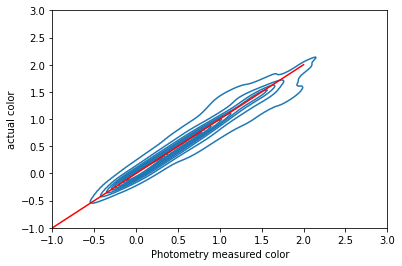

In [ ]:
sns.kdeplot(phot_color[:10000].values, true_color[:10000].values)
plt.xlabel("Photometry measured color")
plt.ylabel("actual color")
plt.xlim(-1,3)
plt.ylim(-1,3)
plt.plot(np.arange(-1,3),np.arange(-1,3),color='r')

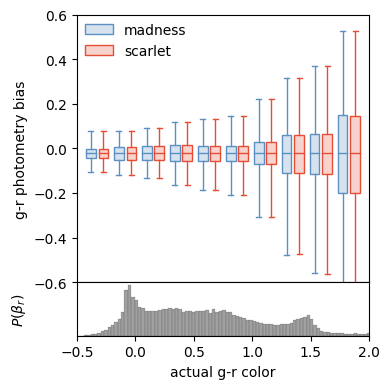

In [ ]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_color_df, 
    x = "gr_truth", y = "gr_phot_bias", z = "type",
    xlim = (-.5, 2),
    ylim = (-.6, .6), 
    x_scale = None,
    legend = ['madness', 'scarlet'],
    x_label='actual g-r color', 
    y_label = 'g-r photometry bias',
    y_label_hist=r'$P(\beta_r)$',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
    nbins = 10,
)
plt.savefig(os.path.join("results", density_level + "_density", "bias_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density",  "bias_color_box_plot.png"))

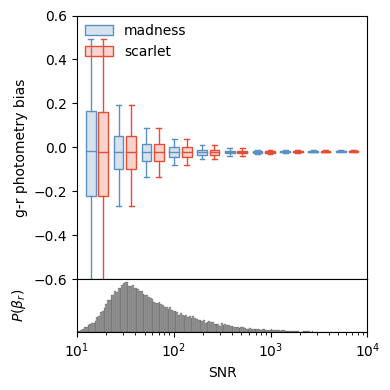

In [ ]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_color_df, 
    x = "snr", y = "gr_phot_bias", z = "type",
    xlim = (10, 10000),
    ylim = (-.6, .6), 
    x_scale = "log",
    legend = ['madness', 'scarlet'],
    x_label='SNR', 
    y_label = 'g-r photometry bias',
    y_label_hist=r'$P(\beta_r)$',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
    nbins = 10,
)
plt.savefig(os.path.join("results", density_level + "_density", "bias_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density",  "bias_color_box_plot.png"))

# Errors from deblender

comparing the gr color obtained apperture photometry between the isolated and deblended cases

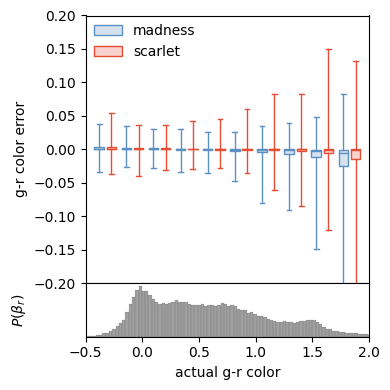

In [ ]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_color_df, 
    x = "gr_phot", y = "gr_color_err_phot", z = "type",
    xlim = (-.5, 2),
    ylim = (-.2, .2), 
    x_scale = None,
    legend = ['madness', 'scarlet'],
    x_label='actual g-r color', 
    y_label = 'g-r color error',
    y_label_hist=r'$P(\beta_r)$',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
    nbins = 10,
)
plt.savefig(os.path.join("results", density_level + "_density", "bias_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density",  "bias_color_box_plot.png"))

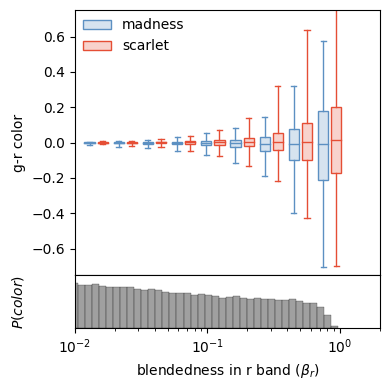

In [ ]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_color_df, 
    x = "r_blendedness", y = "gr_color_err_phot", z = "type",
    xlim = (1e-2, 2),
    ylim = (-.75, .75), 
    x_scale = 'log',
    legend = ['madness', 'scarlet'],
    x_label=r'blendedness in r band ($\beta_r$)', 
    y_label = 'g-r color',
    y_label_hist=r'$P(color)$',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
    nbins = 10,
)
plt.savefig(os.path.join("results", density_level + "_density", "blendedness_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density",  "blendedness_color_box_plot.png"))

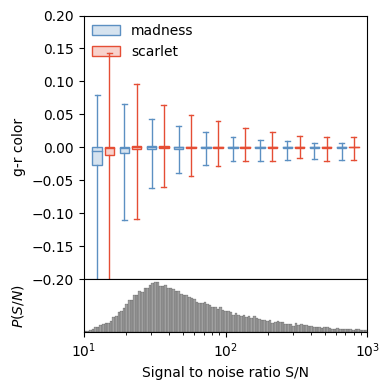

In [ ]:
fig, median_fluxerr, q1_fluxerr, q3_fluxerr, whislo_fluxerr, whishi_fluxerr = maddeb.boxplot.boxplot_func(
    boxplot_color_df, 
    x = 'snr', y = "gr_color_err_phot", z = "type",
    xlim = (10, 1000),
    ylim = (-.2, 0.2), 
    x_scale = 'log',
    legend = ['madness', 'scarlet'],
    x_label='Signal to noise ratio S/N', 
    y_label = 'g-r color',
    y_label_hist=r'$P(S/N)$',
    legend_remove = False,
    whis = [5,95],
    percents = [25,75],
    palette = mpl.cm.RdYlBu([0.85,0.15]),#0.35,
    nbins = 10
)

plt.savefig(os.path.join("results", density_level + "_density", "snr_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density", "snr_color_box_plot.png"))

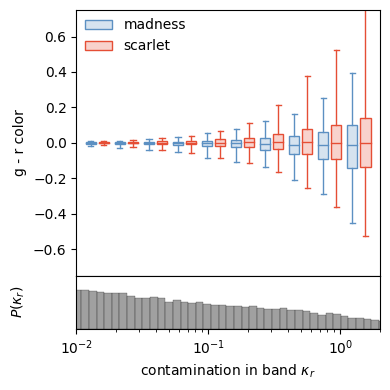

In [ ]:
fig, median_shear, q1_shear, q3_shear, whislo_shear, whishi_shear = maddeb.boxplot.boxplot_func(
    boxplot_color_df, 
    x = 'r_contamination', y = "gr_color_err_phot", z = "type",
    xlim = (1e-2, 2),
    ylim = (-.75, .75), 
    x_scale = 'log',
    legend = ['madness', 'scarlet'],
    x_label=r'contamination in band $\kappa_r$', 
    y_label = 'g - r color',
    y_label_hist=r'$P(\kappa_r)$',
    legend_remove = False,
    whis = [5, 95],
    percents = [25, 75],
    palette=mpl.cm.RdYlBu([0.85,0.15]),#0.35,
    nbins = 10,
)
plt.savefig(os.path.join("results", density_level + "_density", "contamination_color_box_plot.pdf"))
plt.savefig(os.path.join("results", density_level + "_density",  "contamination_color_box_plot.png"))

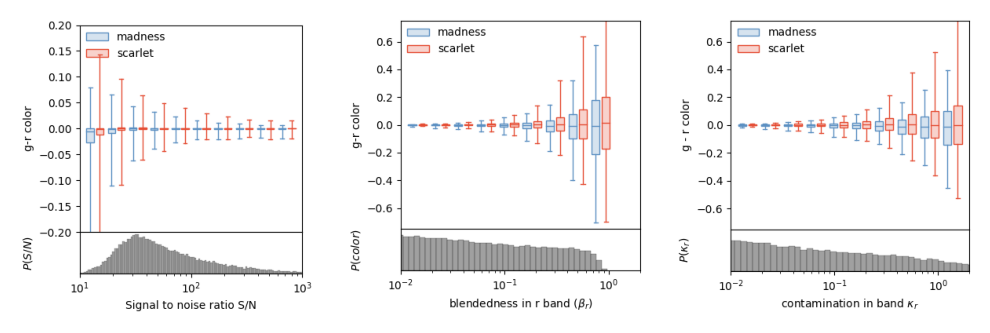

In [ ]:
f, axarr = plt.subplots(1, 3, figsize=(10, 15))

#axarr[0].imshow(mpimg.imread(os.path.join(result_dir_path, "cumulative_distib_phot_err_r.png")))
axarr[0].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "snr_color_box_plot.png")))
axarr[1].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "blendedness_color_box_plot.png")))
axarr[2].imshow(mpimg.imread(os.path.join("results", density_level + "_density", "contamination_color_box_plot.png")))

# turn off x and y axis
[ax.set_axis_off() for ax in axarr.ravel()]
plt.tight_layout()

plt.savefig("results/" + density_level + "_density/" + density_level + "_density_color_boxplot_results.pdf", format="pdf", bbox_inches="tight")
plt.savefig("results/" + density_level + "_density/" + density_level + "_density_color_boxplot_results.png")

plt.show()